Element pattern
====
Last updated: 5 Oct 2018  

This notebook will read a CST antenna pattern file and save in a pickle format data file for use by other notebooks.  


This notebook will also calculate the pattern for a circular disk element using equations from reference [1].  

From Working Group 2 meeting, the element has a directivity of 5.6 dBi at L-Band.  
| Frequency (MHz) | 1435 | 1480 | 1525 |
|:----------------|:----:|:----:|:----:|
| N elements | 140 | 140 | 140 |
| Element directivity (dBi) | 5.6 | 5.6 | 5.6 |


Reference:  
1) Microstrip Antenna Design Handbook, by Ramesh Garg, Prakash Bhartia, Inder Bahl, and Apisak Ittipihoon, Artech House,2001, ISBN 0-89006-513-6.  See page 324 for radiation fields of a circular patch.  

In [1]:
import os
import pickle
import numpy as np
from scipy import special
import matplotlib.pyplot as plt

# Read CST antenna pattern file
For now this is a junk file exported from CST.  The file is from a conformal array of elements.  
Need to pay attenstion to the orientation of theta and phi.  
header from data file:  
```
// CST Farfield Source File
// Version: 3.0 
// Data Type Farfield 
// #Frequencies 1 
// Position 2.255973e-017 0.000000e+000 -8.354133e-002 
// zAxis 0.000000e+000 1.000000e+000 0.000000e+000 
// xAxis 0.000000e+000 0.000000e+000 1.000000e+000 
// Radiated/Accepted/Stimulated Power , Frequency 1.905259e+000 1.981235e+000 2.000000e+000 2.240000e+009 
// >> Total #phi samples, total #theta samples 361 181
// >> Phi, Theta, Re(E_Theta), Im(E_Theta), Re(E_Phi), Im(E_Phi): 
```

In [0]:
# read the pattern data from the CTS file
A = np.loadtxt('Antenn Pattern from CST.ffs')
print('length of data set = {:d} lines'.format(len(A)))

In [0]:
# create arrays to hold the pattern data
step = 1
theta_min = 0
theta_max = 180
phi_min = 0
phi_max = 360
theta = np.arange(theta_min,theta_max+1,step) # include end points
phi = np.arange(phi_min,phi_max+1,step)

E_theta = np.empty((len(theta),len(phi)), dtype=complex)
E_phi = np.empty((len(theta),len(phi)), dtype=complex)

# digest the data
for k in range(len(A)):
    i = int(A[k,1])  # theta index
    j = int(A[k,0])  # phi index
    E_theta[i,j] = A[k,2] + A[k,3]*1J
    E_phi[i,j] = A[k,4] + A[k,5]*1J

In [0]:
# export element pattern
R = np.sqrt(E_theta**2+E_phi**2)
pickle.dump(R, open( "EP.pkl", "wb" ))

In [0]:
# Plot the pattern
F = np.sqrt(E_theta**2+E_phi**2)
F_plt = 20*np.log10(abs(F)) # convert to dB magnitude for plotting
F_plt  = np.clip(F_plt,-40,np.inf) # set limits for plotted data

# re-build theta and phi in terms of deg
theta = np.arange(theta_min,theta_max+1,step) # include end points
phi = np.arange(phi_min,phi_max+1,step)
X1, Y1 = np.meshgrid(phi, theta)

plt.contourf(X1,Y1,F_plt,10)
plt.grid(True)
plt.xlabel('phi')
plt.ylabel('theta')
plt.ylim(theta_min,theta_max)
plt.yticks(np.arange(theta_min, theta_max+1, step=45))
plt.xlim(phi_min,phi_max)
plt.xticks(np.arange(phi_min, phi_max+1, step=45))
plt.colorbar(format='$%.0f$')
plt.show()

In [0]:
# plotting principle plane cuts
plt.plot(theta,F_plt[:,0],'b',label='phi=0')
plt.plot(theta,F_plt[:,45],'r',label='phi=45')
plt.grid(True)
plt.legend()
plt.xlabel('theta')
plt.ylabel('amplitude, dB')
plt.ylim(-10,30)
plt.xlim(theta_min,theta_max)
plt.xticks(np.arange(theta_min, theta_max+1, step=45))
plt.show()

In [0]:
# plot data in polar format
# The 111 specifies 1 row, 1 column on subplot #1
ax = plt.subplot(111, polar=True)
ax.grid(True)
minGrid = -10 #set plot grid
maxGrid = 30
gridSpacing = 5
ax.set_yticks(np.arange(minGrid,maxGrid,gridSpacing))
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.autoscale(enable=False)

# Polar plot
ax.plot(theta*np.pi/180,F_plt[:,0],'b',linewidth = 2,label='phi=0')
ax.plot(theta*np.pi/180,F_plt[:,45],'r',linewidth = 2,label='phi=45')

# Setting the graph title & legend
ax.set_title("test title")
plt.legend()
plt.show()

# Model radiation pattern for a circular disk
Equations 5.19 and 5.20 from reference [1] are used to model a circular disk antenna.  Section 5.2.1 describes a cavity model for the circular element.  Radiation fields are developed from the model.  Assuming a mode corresponding to n = m = 1, the minimum radius and resonance frequency is calculated.  

The far field values obtained from equations 5.19 and 5.20 are adquate for the initial analysis.  Actual radiation patterns will be used when they are available.

See equation 5.17 for V  

$V=hE_nJ_n(X_{nm})$  

V is known as the edge voltage at phi = 0.  
En = electric field for n  
Jn is the Bessel function of order n.  

The far fields are delineated by the condition that:  
$r >> r'$  or $r \geq \frac {2L^2}{\lambda _0}$  
where L is the largest dimension of the aperature.  

In [2]:
# paramters used in the model  <<--- need to fix the values, for now just use ones as place holders 
a = 1 # disk metalization radius
ko = 1 # free space wave number
eo = 1 # free space dielectric constant
er = 1
h = 1 
V = 1 # edge voltage
r = 1 # distance to observation point
n = 1 # order for Bessel function

The E-plane radiation fields should be multiplied by $F_3(\theta)$ and the H-plane data fields should by $F_4(\theta)$ per disscussion in section 4.3 of reference [1].  The above expressions for radiation fields assume that the radiating slots are in free spce.  The effects of theground plane and substraite of the antenna on the radiation pattern can be included by means of factors $F_3(\theta)$ and $F_4(\theta)$, equations 4.41 and 4.42 in reference [1].  Also see 2.59 in chapter two of reference [1].  

Need to model the CBITS element and adjust paramters above.  

Calculate and plot for $\theta$ = $-\pi$ to $\pi$

In [3]:
step = 1
theta_min = -90
theta_max = 90
phi_min = 0
phi_max = 360

theta = np.arange(theta_min,theta_max+1,step,dtype=float) # include end points
theta[np.where(theta == 0)[0]] = 0.001  # remove zero value, prevents divide by zero
theta[0] = theta_min + 0.1 # using -89.9 for -90 prevents divide by zero
theta[-1] = theta_max - 0.1
theta = theta*np.pi/180 # convert to radians
phi = np.arange(phi_min,phi_max,step,dtype=float)*np.pi/180

E_theta = np.zeros((len(theta),len(phi)),dtype=complex)
E_phi = np.zeros((len(theta),len(phi)),dtype=complex)

for i in range(len(theta)):
    for j in range(len(phi)):
        F3n = 2*np.cos(theta[i])*np.sqrt(er-np.sin(theta[i])**2) # F3 numerator
        F3d = np.sqrt(er-np.sin(theta[i])**2) - 1j*er*np.cos(theta[i])*np.arctan(ko*h*np.sqrt(er-np.sin(theta[i])**2)) # F3 denominator
        F3 = (F3n/F3d) # eq 4.41
        E_theta [i,j] = ((-1j**n)*V*a*ko/2)*(np.exp(-1j*ko*r)/r)*np.cos(n*phi[j])*special.jvp(1,ko*a*np.sin(theta[i]))*F3 # eq 5.19

        F4n = 2*np.cos(theta[i]) # F4 numberator
        F4d = np.cos(theta[i]) - 1j*np.sqrt(er-np.sin(theta[i])**2)*np.arctan(ko*h*np.sqrt(er-np.sin(theta[i])**2)) # F4 denominator
        F4 = (F4n/F4d) # eq 4.42
        p1 = (n*(1j**n))*(V*a*ko/2)*(np.exp(-1j*ko*r)/r)
        p2 = np.sin(n*phi[j])*(special.jv(1,ko*a*np.sin(theta[i]))/(ko*a*np.sin(theta[i])))*np.cos(theta[i])
        E_phi[i,j] = p1*p2*F4 # eq 5.20

In [10]:
# normalize the radiation pattern and scale to 5.6 dBi, this is in W and R in in volts <---- need to fix the units and scale
R = np.sqrt(E_theta**2+E_phi**2)
# assume max value is at theta = 0 and phi = 0
R = R/R[int(len(theta)/2),0]

I think the field which is in volts needs to be converted into watts and then into dbi maybe???  or just volts dB

In [9]:
10**(5.6/10)

3.630780547701013

## save to data file

In [11]:
# export element pattern
pickle.dump(R, open( "EP.pkl", "wb" ))

## Plot element pattern

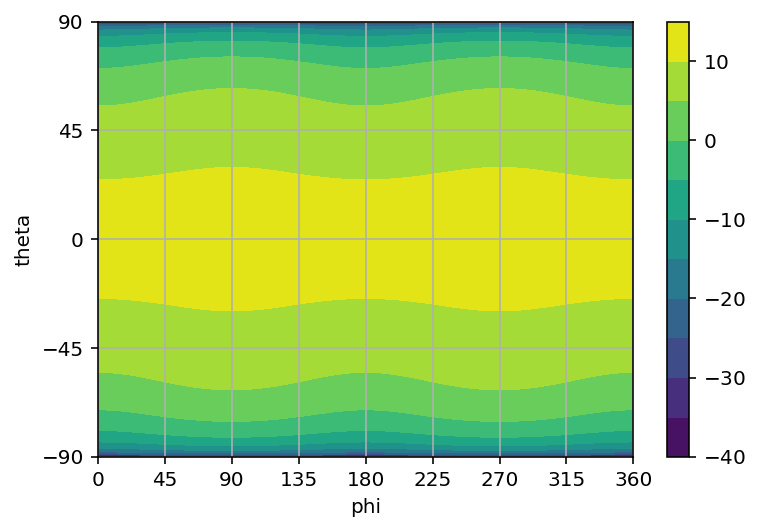

In [12]:
# plot the data
#F = np.sqrt(E_theta**2+E_phi**2)
R_plt = 20*np.log10(abs(R)) # convert to dB magnitude for plotting
R_plt  = np.clip(R_plt,-40,np.inf) # set limits for plotted data

# re-build theta and phi in terms of deg
theta = np.arange(theta_min,theta_max+1,step) # include end points
phi = np.arange(phi_min,phi_max,step)
X1, Y1 = np.meshgrid(phi, theta)

plt.contourf(X1,Y1,R_plt,10)
plt.grid(True)
plt.xlabel('phi')
plt.ylabel('theta')
plt.ylim(theta_min,theta_max)
plt.yticks(np.arange(theta_min, theta_max+1, step=45))
plt.xlim(phi_min,phi_max)
plt.xticks(np.arange(phi_min, phi_max+1, step=45))
plt.colorbar(format='$%.0f$')
plt.show()

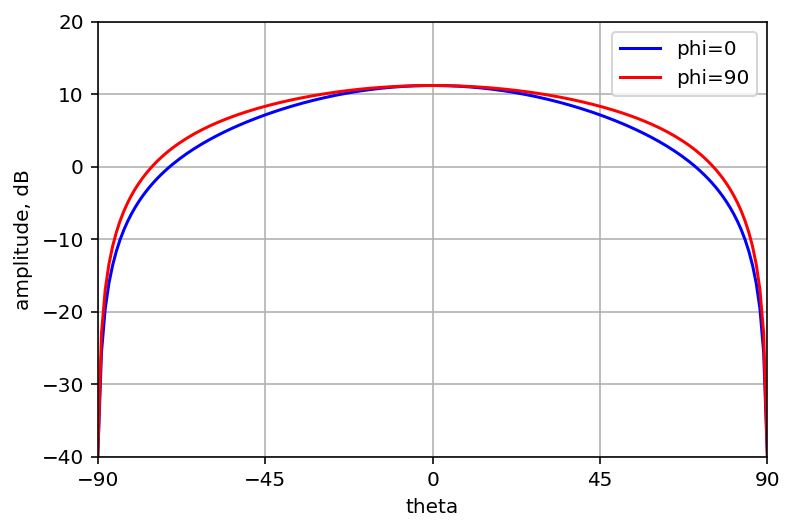

In [14]:
# plotting principle plane cuts
plt.plot(theta,R_plt[:,0],'b',label='phi=0')
plt.plot(theta,R_plt[:,int(90/step)],'r',label='phi=90')
plt.grid(True)
plt.legend()
plt.xlabel('theta')
plt.ylabel('amplitude, dB')
plt.ylim(-40,20)
plt.xlim(theta_min,theta_max)
plt.xticks(np.arange(theta_min, theta_max+1, step=45))
plt.show()

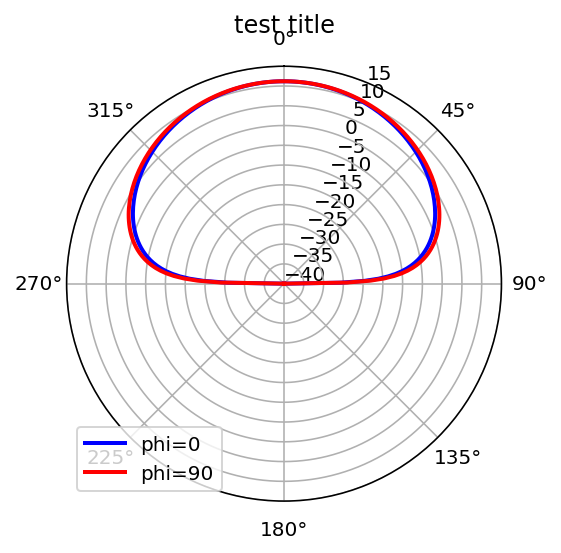

In [18]:
# plot data in polar format
# The 111 specifies 1 row, 1 column on subplot #1
ax = plt.subplot(111, polar=True)
ax.grid(True)
minGrid = -40 #set plot grid
maxGrid = 16
gridSpacing = 5
ax.set_yticks(np.arange(minGrid,maxGrid,gridSpacing))
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.autoscale(enable=False)

# Polar plot
ax.plot(theta*np.pi/180,R_plt[:,0],'b',linewidth = 2,label='phi=0')
ax.plot(theta*np.pi/180,R_plt[:,45],'r',linewidth = 2,label='phi=90')

# Setting the graph title & legend
ax.set_title("test title")
plt.legend()
plt.show()

# OLD CODE

# Read sample input file
This is a one cut from the pattern.  

In [0]:
# read sample patch gain pattern
df1 = pd.read_csv('Pattern data 1E.csv')
num = len(df1)
print('number of lines in data file = {:d}'.format(num))

In [0]:
# show top of data file
df1.head(10)

In [0]:
# read phi and gain values
phi = df1['Phi'].values
gain_dB = df1['Gain_dB'].values

# plot data in polar format
# The 111 specifies 1 row, 1 column on subplot #1
ax = plt.subplot(111, polar=True)
ax.grid(True)
minGrid = -15 #set plot grid
maxGrid = 11
gridSpacing = 5
ax.set_yticks(np.arange(minGrid,maxGrid,gridSpacing))
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.autoscale(enable=False)

# Polar plot
ax.plot(phi*2*np.pi/360,gain_dB, 'b', linewidth = 2, label = 'gain')

# Setting the graph title & legend
ax.set_title("test title")

plt.show()

In [0]:
# make variables theta and phi, need to convert to radians before any math
step = 2  # step size for various ranges
theta = np.arange(0,181,step) # 0 to 180 degrees, include end points
#phi = np.arange(-180,180,step) # 0 to 359 degrees

In [0]:
# make variables theta and phi, need to convert to radians before any math
step = 2  # step size for various ranges
theta = np.arange(-90,91,step) # 0 to 180 degrees, include end points
phi = np.arange(0,360,step) # 0 to 359 degrees

In [0]:
# build full pattern from roll cut pattern
R_dB = np.broadcast_to(gain_dB[0:-1], (len(theta),len(gain_dB)-1))  # full pattern
print('array, number of rows = {:d}'.format(np.shape(R)[0]))
print('array, number of columns = {:d}'.format(np.shape(R)[1]))

In [0]:
# set limits for plot
dB_limit = -40
F = R_dB
#F = 20*np.log10(abs(R)) # convert to dB magnitude
msk1 = F < dB_limit
fill = msk1 * dB_limit
msk2 = F >= dB_limit
R_plt = F * (msk2) + fill

X1, Y1 = np.meshgrid(phi, theta)

plt.contourf(X1,Y1,R_plt,10)
ax.set_aspect('equal', 'box')
plt.grid(True)
plt.xlabel('phi')
plt.ylabel('theta')
plt.ylim(-90,90)
plt.yticks(np.arange(-90, 90+1, step=45))
plt.xlim(0,360)
plt.xticks(np.arange(0, 360+1, step=45))
plt.colorbar(format='$%.0f$')
plt.show()

In [0]:
# plotting principle plane cuts
plt.plot(theta,R_dB[:,0],label='phi=0')
plt.plot(theta,R_dB[:,45],label='phi=90')
plt.grid(True)
plt.legend()
plt.xlabel('theta')
plt.ylabel('amplitude, dB')
plt.ylim(-15,10)
plt.xlim(-90,90)
plt.xticks(np.arange(-90, 90+1, step=45))
plt.show()

In [0]:
# plot data in polar format
# The 111 specifies 1 row, 1 column on subplot #1
ax = plt.subplot(111, polar=True)
ax.grid(True)
minGrid = -15 #set plot grid
maxGrid = 11
gridSpacing = 5
ax.set_yticks(np.arange(minGrid,maxGrid,gridSpacing))
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.autoscale(enable=False)

# Polar plot
ax.plot(theta*np.pi/180,R_dB[:,0],'b',linewidth = 2,label='phi=0')
ax.plot(theta*np.pi/180,R_dB[:,45],'r',linewidth = 2,label='phi=90')

# Setting the graph title & legend
ax.set_title("test title")
plt.legend()
plt.show()

In [0]:
# export element pattern
R = 10**(R_dB/10)
pickle.dump(R, open( "EP.pkl", "wb" ))

Microstrip Antenna Design Handbook, by Ramesh Garg, Prakash Bhartia, Inder Bahl, and Apisak Ittipihoon, Artech House,2001, ISBN 0-89006-513-6.  
see page 324 for radiation fields of a circular patch

In [0]:
from scipy import special

In [0]:
special.jnp_zeros(1, 2)

In [0]:
special.j0(1)

# calculated field for a rectangular patch
get reference  
2 cells below aren't used, maybe delete   

In [0]:
# starting parameters
f = 2300e6 # Hz
c = 299792458 # speed of light m/s
Lam = c/f
print("free space lambda = {:.3f} in".format(Lam*37.39))
ko = 2*np.pi/Lam
er = 2.32 # 2.3 for duroid

In [0]:
# calculate width and length of a patch
h = 3.048e-3  # height of slot above ground plane
# calculate patch dimensions, centameters
W = c/(2*f)*((er+1)/2)**(-1/2)
e_eff = ((er+1)/2)+((er-1)/2)*(1+12*h/W)**(-1/2)
dl = h*0.412*((er+0.3)*(W/h+0.264))/((er-0.258)*(W/h+0.8))
L = c/(2*f*np.sqrt(e_eff))-2*dl
print("effective er: {:.3f}".format(e_eff))
print("patch length: {:.3f} in".format(L*37.39))
print("patch width: {:.3f} in".format(W*37.39))
print("patch lambda = {:.3f} in".format(Lam*37.39/e_eff))

# Calculated field for a idealized patch antenna
See reference for normalized radiation pattern.  
http://www.antenna-theory.com/antennas/patches/antenna.php  

In [0]:
# values used in ref
Lam = 1
W = Lam/2
L = Lam/2

In [0]:
# make variables theta and phi and convert to radians
step = 2  # step size for various ranges
theta_min = 0.1 # errors on 0
theta_max = 180
phi_min = 0.1
phi_max = 360
# convert deg to radians
theta = np.arange(theta_min,theta_max+1,step)*np.pi/180 # include end points
phi = np.arange(phi_min,phi_max,step)*np.pi/180

In [0]:
k = 2*np.pi/Lam
E_theta = np.zeros((len(theta),len(phi)))
E_phi = np.zeros((len(theta),len(phi)))

for i in range(len(theta)):
    for j in range(len(phi)):
        n1 = np.sin(k*W*np.sin(theta[i])*np.sin(phi[j]))
        d1 = k*W*np.sin(theta[i])*np.sin(phi[j])/2
        p1 = n1/d1
        p2 = np.cos(k*L*np.sin(theta[i])*np.cos(phi[j])/2)*np.cos(phi[j])
        E_theta[i,j] = p1*p2

        n1 = -np.sin(k*W*np.sin(theta[i])*np.sin(phi[j])/2)
        d1 = k*W*np.sin(theta[i])*np.sin(phi[j])/2
        p1 = n1/d1
        p2 = np.cos(k*L*np.sin(theta[i])*np.cos(phi[j])/2)*np.cos(theta[i])*np.sin(phi[j])
        E_phi[i,j] = p1*p2

F = np.sqrt(E_theta**2+E_phi**2)

In [0]:
# export element pattern
pickle.dump(F, open( "EP.pkl", "wb" ))

# plot the pattern

In [0]:
F_plt = 20*np.log10(abs(F)) # convert to dB magnitude for plotting
F_plt  = np.clip(F_plt,-40,np.inf) # set limits for plotted data

# re-build theta and phi in terms of deg
theta_min = 0
theta_max = 180
phi_min = 0
phi_max = 360
theta = np.arange(theta_min,theta_max+1,step) # include end points
phi = np.arange(phi_min,phi_max,step)
X1, Y1 = np.meshgrid(phi, theta)

plt.contourf(X1,Y1,F_plt,10)
plt.axis('image')
#ax.set_aspect('equal', 'box')
plt.grid(True)
plt.xlabel('phi')
plt.ylabel('theta')
plt.ylim(theta_min,theta_max)
plt.yticks(np.arange(theta_min, theta_max+1, step=45))
plt.xlim(phi_min,phi_max)
plt.xticks(np.arange(phi_min, phi_max+1, step=45))
plt.colorbar(format='$%.0f$')
plt.show()

In [0]:
# plotting principle plane cuts
plt.plot(theta,F_plt[:,0],'b',label='phi=0')
plt.plot(theta,F_plt[:,45],'r',label='phi=90')
plt.grid(True)
plt.legend()
plt.xlabel('theta')
plt.ylabel('amplitude, dB')
plt.ylim(-40,10)
plt.xlim(theta_min,theta_max)
plt.xticks(np.arange(theta_min, theta_max+1, step=45))
plt.show()

In [0]:
# plot data in polar format
# The 111 specifies 1 row, 1 column on subplot #1
ax = plt.subplot(111, polar=True)
ax.grid(True)
minGrid = -40 #set plot grid
maxGrid = 11
gridSpacing = 5
ax.set_yticks(np.arange(minGrid,maxGrid,gridSpacing))
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.autoscale(enable=False)

# Polar plot
ax.plot(theta*np.pi/180,F_plt[:,0],'b',linewidth = 2,label='phi=0')
ax.plot(theta*np.pi/180,F_plt[:,45],'r',linewidth = 2,label='phi=90')

# Setting the graph title & legend
ax.set_title("test title")
plt.legend()
plt.show()

# Microstrip Antenna Design Handbook
Following some examples and equations in the book.  

The far fields are delineated by the condition that:  
$r >> r'$  or  
$r \geq \frac {2L^2}{\lambda _0}$  
  
where L is the largest dimension of the aperature.  
Ref:  
Microstrip Antenna Design Handbook, by Ramesh Garg, Prakash Bhartia, Inder Bahl, and Apisak Ittipihoon, Artech House,2001, ISBN 0-89006-513-6.

In [0]:
# radiation pattern for an aperature of dimensions h x W
# example on page 37-38
W = 1 # width of current sheet
h = 1 # height over ground plane
ko = 1 # free space wave number
eo = 1 # free space dielectric constant
Vo = 1 # ???  My = Vo/h eq 1.27
r = 1 # distance to observation point

# define theta and phi in terms of deg
step = 2
theta_min = 0
theta_max = 180
phi_min = 0
phi_max = 360
theta = np.arange(theta_min,theta_max+1,step) # include end points
phi = np.arange(phi_min,phi_max,step)

In [0]:
theta = np.arange(theta_min,theta_max+1,step)*np.pi/180 # include end points
phi = np.arange(phi_min,phi_max,step)*np.pi/180
E_theta = np.zeros((len(theta),len(phi)),dtype=complex)
E_phi = np.zeros((len(theta),len(phi)),dtype=complex)

for i in range(len(theta)):
    for j in range(len(phi)):
        p1 = -1j*ko*Vo*W*(np.exp(-1j*ko*r))/(4*np.pi*r)
        p2 = np.sinc(ko*h*np.sin(theta[i])*np.cos(phi[j]/2))
        p3 = np.sinc(ko*W*np.sin(theta[i])*np.sin(phi[j]/2))*np.cos(phi[j])
        E_theta[i,j] = p1*p2*p3

        p1 = -1j*ko*Vo*W*(np.exp(-1j*ko*r))/(4*np.pi*r)
        p2 = np.sinc(ko*h*np.sin(theta[i])*np.cos(phi[j]/2))
        p3 = np.sinc(ko*W*np.sin(theta[i])*np.sin(phi[j]/2))*np.cos(theta[i])*np.sin(phi[j])
        E_phi[i,j] = p1*p2*p3

# Radiation pattern for a circular disk
Various mathematical models have been suggested for predicting the radiation characteristics of a circular disk microstrip radiator.  The far field expression obtained from the cavity model are symple and adquate for practical purposes.  
Probaly could just use more simple geometric shapes.  
equations from page 342  

one inferes that the mode corresponding to n=m=1 has the minimum radius or resonance frequency and is known as the dominate mode.  
See equation 5.17 for V  
$V=hE_nJ_n(X_{nm})$  
V is known as the edge voltage at phi = 0.  

En = electric field for n

Jn is the Bessel function of order n.  


In [0]:
from scipy import special

In [0]:
# paramters used in the model
a = 1 # disk metalization radius
ko = 1 # free space wave number
eo = 1 # free space dielectric constant
V = 1 # edge voltage
r = 1 # distance to observation point
n = 1 # order for Bessel function

In [0]:
step = 2
theta_min = 0.1  # prevents divide by zero
theta_max = 180
phi_min = 0
phi_max = 360

theta = np.arange(theta_min,theta_max+1,step)*np.pi/180 # include end points
phi = np.arange(phi_min,phi_max,step)*np.pi/180
E_theta = np.zeros((len(theta),len(phi)),dtype=complex)
E_phi = np.zeros((len(theta),len(phi)),dtype=complex)

for i in range(len(theta)):
    for j in range(len(phi)):
        E_theta [i,j] = (-1j*V*a*ko/2)*(np.exp(-1j*ko*r)/r)*np.cos(n*phi[j])*special.jvp(1,ko*np.sin(theta[i]))

        p1 = (1j*V*a*ko/2)*np.exp(-1j*ko*r)/r
        p2 = special.jv(1,ko*np.sin(theta[i]))/(ko*a*np.sin(theta[i]))
        p3 = np.cos(theta[i])*np.sin(phi[j])
        E_phi[i,j] = p1*p2*p3

The E-plane radiation fields should be multiplied by $F_3(\theta)$ and the H-plane data fields should by $F_4(\theta)$.  The simplest approximatin is a multiplication factor of 2.

In [0]:
F3 = (2*cos(theta)*sqrt(er-sin(theta)**2))/((sqrt(er-sin(theta)**))-1j*er*cos(theta)*cot(ko*h*sqrt(er-sin(theta)**2)))
F4 = 2*cos(theta)/(cos(theta)-1j*sqrt(er-sin(theta)**2)*cot(ko*h*sqrt(er-sin(theta)**2)))

In [0]:
# save to data file

In [0]:
F = np.sqrt(E_theta**2+E_phi**2)

In [0]:
F_plt = 20*np.log10(abs(F)) # convert to dB magnitude for plotting
F_plt  = np.clip(F_plt,-40,np.inf) # set limits for plotted data

# re-build theta and phi in terms of deg
theta_min = 0
theta_max = 180
phi_min = 0
phi_max = 360
theta = np.arange(theta_min,theta_max+1,step) # include end points
phi = np.arange(phi_min,phi_max,step)
X1, Y1 = np.meshgrid(phi, theta)

plt.contourf(X1,Y1,F_plt,10)
plt.axis('image')
#ax.set_aspect('equal', 'box')
plt.grid(True)
plt.xlabel('phi')
plt.ylabel('theta')
plt.ylim(theta_min,theta_max)
plt.yticks(np.arange(theta_min, theta_max+1, step=45))
plt.xlim(phi_min,phi_max)
plt.xticks(np.arange(phi_min, phi_max+1, step=45))
plt.colorbar(format='$%.0f$')
plt.show()

In [0]:
# plotting principle plane cuts
plt.plot(theta,F_plt[:,0],'b',label='phi=0')
plt.plot(theta,F_plt[:,45],'r',label='phi=90')
plt.grid(True)
plt.legend()
plt.xlabel('theta')
plt.ylabel('amplitude, dB')
plt.ylim(-40,10)
plt.xlim(theta_min,theta_max)
plt.xticks(np.arange(theta_min, theta_max+1, step=45))
plt.show()

In [0]:
# plot data in polar format
# The 111 specifies 1 row, 1 column on subplot #1
ax = plt.subplot(111, polar=True)
ax.grid(True)
minGrid = -40 #set plot grid
maxGrid = 11
gridSpacing = 5
ax.set_yticks(np.arange(minGrid,maxGrid,gridSpacing))
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.autoscale(enable=False)

# Polar plot
ax.plot(theta*np.pi/180,F_plt[:,0],'b',linewidth = 2,label='phi=0')
ax.plot(theta*np.pi/180,F_plt[:,45],'r',linewidth = 2,label='phi=90')

# Setting the graph title & legend
ax.set_title("test title")
plt.legend()
plt.show()